In [1]:
# get tuned alg results for each split separately

import pandas as pd
import numpy as np

metadataset_df = pd.read_csv("./results/tuned_fold_results.csv")

# Develop outcome measures for each dataset split

In [2]:
# categorize each alg

neural_algs = [
    "MLP",
    "TabNet",
    "VIME",
    "TabTransformer",
    "NODE",
    "STG",
    "NAM",
    "DeepFM",
    "SAINT",
    "DANet",
    "rtdl_MLP",
    "rtdl_ResNet",
    "rtdl_FTTransformer",
    "TabPFNModel"
]

tree_algs = [
    "LightGBM",
    "XGBoost",
    "CatBoost"
]

baseline_algs = [
    "DecisionTree",
    "RandomForest",
    "LinearModel",
    "KNN",
    "SVM",
]

metadataset_df.loc[:, "alg_type"] = "baseline"
metadataset_df.loc[metadataset_df["alg_name"].isin(neural_algs), "alg_type"] = "neural"
metadataset_df.loc[metadataset_df["alg_name"].isin(tree_algs), "alg_type"] = "trees"

print(metadataset_df.groupby("alg_type")["alg_name"].value_counts())

alg_type  alg_name          
baseline  DecisionTree          1710
          RandomForest          1700
          LinearModel           1670
          KNN                   1640
          SVM                   1430
neural    rtdl_MLP              1710
          MLP                   1700
          rtdl_ResNet           1700
          TabNet                1660
          STG                   1630
          VIME                  1620
          DANet                 1470
          rtdl_FTTransformer    1390
          NODE                  1380
          TabTransformer        1220
          SAINT                 1060
          DeepFM                 900
          NAM                    800
          TabPFNModel            630
trees     XGBoost               1710
          LightGBM              1640
          CatBoost              1630
Name: alg_name, dtype: int64


In [4]:
# get best-performing alg type for each dataset split
best_alg_df_dict = {}

metric_list = [
    "Accuracy",
    "F1",
    "Log Loss",
]

for metric in metric_list:

    df_metric = metadataset_df.loc[metadataset_df[f"{metric}_rank"] == 1, :]

    # get a list of all top-ranked algs for each dataset split
    best_algs = df_metric.groupby("dataset_fold_id")["alg_type"].apply(lambda x: set(x)).reset_index()

    # add a binary col indicating whether best alg includes each alg class
    for alg_type in ["trees", "neural", "baseline"]:
        best_algs.loc[:, f"{alg_type}_win"] = best_algs["alg_type"].apply(lambda x: alg_type in x)

    best_alg_df_dict[metric] = best_algs

In [5]:
metafeatures_df = pd.read_csv("../TabSurvey/metafeatures.csv")

no_nan_metafeatures = metafeatures_df.isna().sum() == 0
print(f"number of metafeatures with no nans: {sum(no_nan_metafeatures)}")
print(f"number of metafeatures with nans:    {sum(~no_nan_metafeatures)}")

# keep only metafeatures with no nans...
keep_metafeatures_df = metafeatures_df.loc[:, set(["dataset_name"] + list(no_nan_metafeatures[no_nan_metafeatures].index))]

number of metafeatures with no nans: 443
number of metafeatures with nans:    1162


In [6]:
# merge on dataset split name
for metric in metric_list:
    best_alg_df_dict[metric] = best_alg_df_dict[metric].merge(keep_metafeatures_df, left_on="dataset_fold_id", right_on="dataset_name", how="left")

In [32]:
# # run a lasso regression on accuracy using dataset metafeatures
# from sklearn.linear_model import LassoCV
# from sklearn.linear_model import LogisticRegression

# metric = "Accuracy"
# df = best_alg_df_dict[metric]

# target_col = "neural_win"
# feature_cols = [c for c in df.columns if c.startswith("f__")]

# # drop instances where the target is nan
# # keep_instances = ~df[target_col].isna()
# y = df.loc[:, target_col].astype(int).values
# x = df.loc[:, feature_cols].values

# # clf = LassoCV(cv=3, random_state=0).fit(x, y)
# clf = LogisticRegression(penalty="l1", max_iter=10000).fit(x, y)







# abs_coef = np.abs(clf.coef_)[0]

# idx_sorted = (-abs_coef).argsort()
# # threshold = importance[idx_third] + 0.01

# num_print_feats = 20

# for i in range(num_print_feats):
#     print(f"{feature_cols[idx_sorted[i]]}: {abs_coef[idx_sorted[i]]}")
# # for 
# # # 
# # idx_features = (-importance).argsort()
# # name_features = np.array(feature_names)[idx_features]
# # print('Selected features: {}'.format(name_features))

In [35]:
# train decision tree
from sklearn import tree


metric = "Accuracy"
df = best_alg_df_dict[metric]

target_col = "alg_type"
feature_cols = [c for c in df.columns if c.startswith("f__")]

y = df.loc[:, target_col].astype(str).values
x = df.loc[:, feature_cols].values

clf = tree.DecisionTreeClassifier(max_depth=3).fit(x, y)

[Text(0.5, 0.875, 'f__pymfe.general.nr_inst <= 2027.5\ngini = 0.8\nsamples = 1710\nvalue = [8, 142, 41, 21, 163, 474, 117, 23, 86, 109, 526]'),
 Text(0.25, 0.625, 'f__pymfe.general.nr_inst <= 120.5\ngini = 0.841\nsamples = 905\nvalue = [6, 116, 38, 9, 102, 273, 95, 17, 76, 70, 103]'),
 Text(0.125, 0.375, 'f__pymfe.statistical.sparsity.median <= 0.233\ngini = 0.823\nsamples = 162\nvalue = [1, 20, 8, 2, 5, 26, 49, 2, 29, 14, 6]'),
 Text(0.0625, 0.125, 'gini = 0.836\nsamples = 108\nvalue = [1, 17, 6, 1, 3, 23, 21, 1, 22, 11, 2]'),
 Text(0.1875, 0.125, 'gini = 0.696\nsamples = 54\nvalue = [0, 3, 2, 1, 2, 3, 28, 1, 7, 3, 4]'),
 Text(0.375, 0.375, 'f__pymfe.statistical.sparsity.range <= 1.0\ngini = 0.823\nsamples = 743\nvalue = [5, 96, 30, 7, 97, 247, 46, 15, 47, 56, 97]'),
 Text(0.3125, 0.125, 'gini = 0.82\nsamples = 733\nvalue = [5, 96, 30, 7, 97, 247, 46, 15, 37, 56, 97]'),
 Text(0.4375, 0.125, 'gini = 0.0\nsamples = 10\nvalue = [0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0]'),
 Text(0.75, 0.625, 'f_

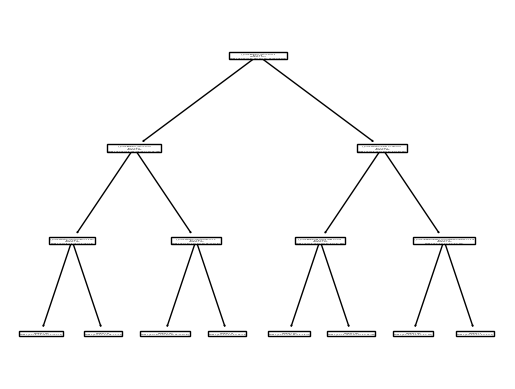

In [37]:
tree.plot_tree(clf, feature_names=feature_cols)

In [16]:
# merged_df["f__pymfe.statistical.iq_range"]
merged_df["f__pymfe.relative.worst_node.skewness"].isna()
 

0        1.308457
1             NaN
2             NaN
3             NaN
4             NaN
           ...   
31995   -1.639149
31996   -1.280722
31997   -2.276840
31998   -2.276840
31999         NaN
Name: f__pymfe.relative.worst_node.skewness, Length: 32000, dtype: float64

In [71]:
for i in feature_cols: print(i)

f__pymfe.landmarking.one_nn.histogram.8.relative
f__pymfe.relative.linear_discr.histogram.7.relative
f__pymfe.relative.naive_bayes.range.relative
f__pymfe.relative.elite_nn.histogram.1.relative
f__pymfe.landmarking.elite_nn.max.relative
f__pymfe.landmarking.random_node.histogram.4.relative
f__pymfe.landmarking.best_node.histogram.9.relative
f__pymfe.relative.one_nn.histogram.6.relative
f__pymfe.relative.naive_bayes.iq_range.relative
f__pymfe.statistical.sparsity.histogram.6
f__pymfe.relative.worst_node.quantiles.1.relative
f__pymfe.landmarking.one_nn.quantiles.4.relative
f__pymfe.landmarking.random_node.max.relative
f__pymfe.landmarking.one_nn.count
f__pymfe.relative.elite_nn.skewness.relative
f__pymfe.landmarking.elite_nn.sd.relative
f__pymfe.landmarking.elite_nn.histogram.6.relative
f__pymfe.relative.linear_discr.histogram.4.relative
f__pymfe.relative.one_nn.count
f__pymfe.landmarking.naive_bayes.min.relative
f__pymfe.relative.naive_bayes.histogram.2.relative
f__pymfe.landmarking.nai

In [70]:
no_nan_metafeatures["f__pymfe.general.attr_to_inst"]

True